An old notebook for modeling data – using an iterative approach for creating running averages of a user's history for skipped and not-skipped tracks respectively, in an attempt to fix the previous issue with leaking target data.

For the notebook with the final model, see [lgbm_model_single_history.ipynb](lgbm_model_single_history.ipynb)

In [1]:
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

/Users/Austin/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [5]:
# Load in the training set
training_set = pd.read_csv("data/mini_data/data/training_set/log_mini.csv")
training_set.hist_user_behavior_reason_start = training_set.hist_user_behavior_reason_start.astype('category')
training_set.hist_user_behavior_reason_end = training_set.hist_user_behavior_reason_end.astype('category')
training_set.context_type = training_set.context_type.astype('category')
training_set.date = training_set.date.apply(pd.to_datetime)

# Load in the track features
track_data = pd.read_pickle("data/pickles/track_features.pkl")

# Using skip_2 as the ground truth
training_set['skipped'] = (training_set.skip_2 | training_set.skip_1).astype('int32')
training_set = training_set.drop(columns=['skip_1','skip_2','skip_3','not_skipped'])

In [6]:
# Convert the columns to all be consistantly numeric
track_data.iloc[:,1:] = track_data.iloc[:,1:].astype('float32')
track_data.head()

,track_id,duration,release_year,us_popularity_estimate,acousticness,beat_strength,bounciness,danceability,dyn_range_mean,energy,...,time_signature,valence,acoustic_vector_0,acoustic_vector_1,acoustic_vector_2,acoustic_vector_3,acoustic_vector_4,acoustic_vector_5,acoustic_vector_6,acoustic_vector_7
0,t_a540e552-16d4-42f8-a185-232bd650ea7d,109.706673,1950.0,99.975418,0.458040,0.519497,0.504949,0.399767,7.511880,0.817709,...,4.0,0.935512,-0.033284,-0.411896,-0.028580,0.349438,0.832467,-0.213871,-0.299464,-0.675907
1,t_67965da0-132b-4b1e-8a69-0ef99b32287c,187.693329,1950.0,99.969429,0.916272,0.419223,0.545530,0.491235,9.098376,0.154258,...,3.0,0.359675,0.145703,-0.850372,0.123860,0.746904,0.371803,-0.420558,-0.213120,-0.525795
2,t_0614ecd3-a7d5-40a1-816e-156d5872a467,160.839996,1951.0,99.602547,0.812884,0.425890,0.508280,0.491625,8.368670,0.358813,...,4.0,0.726769,0.021720,-0.743634,0.333247,0.568447,0.411094,-0.187749,-0.387599,-0.433496
3,t_070a63a0-744a-434e-9913-a97b02926a29,175.399994,1951.0,99.665016,0.396854,0.400934,0.359990,0.552227,5.967346,0.514585,...,4.0,0.859075,0.039143,-0.267555,-0.051825,0.106173,0.614825,-0.111419,-0.265953,-0.542753
4,t_d6990e17-9c31-4b01-8559-47d9ce476df1,369.600006,1951.0,99.991760,0.728831,0.371328,0.335115,0.483044,5.802681,0.721442,...,4.0,0.562343,0.131931,-0.292523,-0.174819,-0.034422,0.717229,-0.016239,-0.392694,-0.455496


In [7]:
# Join the two together
session_data = (
    training_set[['session_id','session_position','track_id_clean', 'skipped']]
    .merge(
        track_data,
        how='left',
        left_on=['track_id_clean'],
        right_on=['track_id']
    ).drop(columns='track_id_clean')
)
session_data.head()

,session_id,session_position,skipped,track_id,duration,release_year,us_popularity_estimate,acousticness,beat_strength,bounciness,...,time_signature,valence,acoustic_vector_0,acoustic_vector_1,acoustic_vector_2,acoustic_vector_3,acoustic_vector_4,acoustic_vector_5,acoustic_vector_6,acoustic_vector_7
0,0_00006f66-33e5-4de7-a324-2d18e439fc1e,1,0,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,180.066666,2018.0,99.968132,0.015848,0.438551,0.473455,...,4.0,0.152255,-0.815775,0.386409,0.230160,0.028028,-0.333373,0.015452,-0.353590,0.205826
1,0_00006f66-33e5-4de7-a324-2d18e439fc1e,2,0,t_9099cd7b-c238-47b7-9381-f23f2c1d1043,236.796371,2018.0,99.896729,0.061811,0.654804,0.735661,...,4.0,0.337152,-0.713646,0.363718,0.310315,-0.042222,-0.383164,0.066357,-0.365308,0.157920
2,0_00006f66-33e5-4de7-a324-2d18e439fc1e,3,0,t_fc5df5ba-5396-49a7-8b29-35d0d28249e0,231.266663,2018.0,99.999977,0.354116,0.532155,0.540411,...,4.0,0.373862,-0.742541,0.375599,0.252660,-0.049007,-0.299745,0.063341,-0.486689,0.181604
3,0_00006f66-33e5-4de7-a324-2d18e439fc1e,4,0,t_23cff8d6-d874-4b20-83dc-94e450e8aa20,169.826675,2018.0,99.995041,0.769225,0.641756,0.729224,...,4.0,0.649420,-0.705116,0.317562,0.289141,-0.038920,-0.393358,0.092719,-0.364418,0.285603
4,0_00006f66-33e5-4de7-a324-2d18e439fc1e,5,0,t_64f3743c-f624-46bb-a579-0f3f9a07a123,210.545258,2018.0,99.998497,0.006602,0.732428,0.794881,...,4.0,0.652921,-0.868489,0.331280,0.210478,0.084740,-0.333287,-0.025706,-0.510350,0.182315


In [8]:
session_data[
    (session_data.session_id == "0_00006f66-33e5-4de7-a324-2d18e439fc1e") &
    (session_data.session_position < 5) &
    (session_data.skipped == 0)
].mean()

session_position             2.500000
skipped                      0.000000
duration                   204.489094
release_year              2018.000000
us_popularity_estimate      99.964970
acousticness                 0.300250
beat_strength                0.566817
bounciness                   0.619688
danceability                 0.768778
dyn_range_mean               9.580541
energy                       0.593196
flatness                     1.020907
instrumentalness             0.000873
key                          4.750000
liveness                     0.255593
loudness                    -6.373750
mechanism                    0.694218
mode                         0.750000
organism                     0.338063
speechiness                  0.101541
tempo                      130.268248
time_signature               4.000000
valence                      0.378172
acoustic_vector_0           -0.744269
acoustic_vector_1            0.360822
acoustic_vector_2            0.270569
acoustic_vec

In [9]:
# Create two dataframes to hold attribute averages for session skips and plays
skip_data = session_data.copy().set_index(['session_id','session_position'])
play_data = session_data.copy().set_index(['session_id','session_position'])
skip_data.head()

skipped  \
session_id                             session_position            
0_00006f66-33e5-4de7-a324-2d18e439fc1e 1                       0   
                                       2                       0   
                                       3                       0   
                                       4                       0   
                                       5                       0   

                                                                                       track_id  \
session_id                             session_position                                           
0_00006f66-33e5-4de7-a324-2d18e439fc1e 1                 t_0479f24c-27d2-46d6-a00c-7ec928f2b539   
                                       2                 t_9099cd7b-c238-47b7-9381-f23f2c1d1043   
                                       3                 t_fc5df5ba-5396-49a7-8b29-35d0d28249e0   
                                       4                 t_23cff8d6-d874-4b20-83dc-94e450e8aa20   
                                       5                 t_64f3743c-f624-46bb-a579-0f3f9a07a123   

                                                           duration  \
session_id                             session_position               
0_00006f66-33e5-4de7-a324-2d18e439fc1e 1                 180.066666   
                                       2                 236.796371   
                                       3                 231.266663   
                                       4                 169.826675   
                                       5                 210.545258   

                                                         release_year  \
session_id                             session_position                 
0_00006f66-33e5-4de7-a324-2d18e439fc1e 1                       2018.0   
                                       2                       2018.0   
                                       3                       2018.0   
                                       4                       2018.0   
                                       5                       2018.0   

                                                         us_popularity_estimate  \
session_id                             session_position                           
0_00006f66-33e5-4de7-a324-2d18e439fc1e 1                              99.968132   
                                       2                              99.896729   
                                       3                              99.999977   
                                       4                              99.995041   
                                       5                              99.998497   

                                                         acousticness  \
session_id                             session_position                 
0_00006f66-33e5-4de7-a324-2d18e439fc1e 1                     0.015848   
                                       2                     0.061811   
                                       3                     0.354116   
                                       4                     0.769225   
                                       5                     0.006602   

                                                         beat_strength  \
session_id                             session_position                  
0_00006f66-33e5-4de7-a324-2d18e439fc1e 1                      0.438551   
                                       2                      0.654804   
                                       3                      0.532155   
                                       4                      0.641756   
                                       5                      0.732428   

                                                         bounciness  \
session_id                             session_position               
0_00006f66-33e5-4de7-a324-2d18e439fc1e 1                   0.473455   
                                       2          

In [10]:
skip_data.loc['0_00006f66-33e5-4de7-a324-2d18e439fc1e',1]

skipped                                                        0
track_id                  t_0479f24c-27d2-46d6-a00c-7ec928f2b539
duration                                                 180.067
release_year                                                2018
us_popularity_estimate                                   99.9681
acousticness                                           0.0158484
beat_strength                                           0.438551
bounciness                                              0.473455
danceability                                            0.653119
dyn_range_mean                                           7.66002
energy                                                  0.553465
flatness                                                 1.03501
instrumentalness                                      0.00348447
key                                                            1
liveness                                                0.678553
loudness                 

In [16]:
from multiprocessing import Pool

def update_skip_row(df, skip_df, play_df, sid, spos):
    skip_df_series = df[
        (df.session_id == sid) &
        (df.session_position < spos) &
        (df.skipped == 1)
    ].mean()
    return skip_df_series

def update_play_row(df, skip_df, play_df, sid, spos):
    play_df_series = df[
        (df.session_id == sid) &
        (df.session_position < spos) &
        (df.skipped == 0)
    ].mean()
    return play_df_series

def df_skip_map(index):
    sid, spos = index
    skip_df_series = update_skip_row(session_data, skip_data, play_data, sid, spos)
    return skip_df_series

def df_play_map(index):
    sid, spos = index
    play_df_series = update_play_row(session_data, skip_data, play_data, sid, spos)
    return play_df_series

with Pool() as p:
    skip_data = p.map(df_skip_map,session_data[['session_id','session_position']].values)
    skip_data = pd.DataFrame(skip_data)
    
with Pool() as p:
    play_data = p.map(df_play_map,session_data[['session_id','session_position']].values)
    play_data = pd.DataFrame(play_data)

In [29]:
skip_data = skip_data.drop(columns=['skip_avg_session_id','skip_avg_session_position','skip_avg_track_id','skip_avg_skipped'],errors='ignore')
play_data = play_data.drop(columns=['play_avg_session_id','play_avg_session_position','play_avg_track_id','play_avg_skipped'],errors='ignore')

In [30]:
skip_data.head(20)

,skip_avg_duration,skip_avg_release_year,skip_avg_us_popularity_estimate,skip_avg_acousticness,skip_avg_beat_strength,skip_avg_bounciness,skip_avg_danceability,skip_avg_dyn_range_mean,skip_avg_energy,skip_avg_flatness,...,skip_avg_time_signature,skip_avg_valence,skip_avg_acoustic_vector_0,skip_avg_acoustic_vector_1,skip_avg_acoustic_vector_2,skip_avg_acoustic_vector_3,skip_avg_acoustic_vector_4,skip_avg_acoustic_vector_5,skip_avg_acoustic_vector_6,skip_avg_acoustic_vector_7
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,186.453323,2018.0,99.861565,0.449629,0.487708,0.608612,0.557520,9.834414,0.469350,1.033029,...,4.000000,0.109420,-0.748412,0.321976,0.237488,0.003480,-0.315287,0.032431,-0.464694,0.200836
8,200.250336,2018.0,98.552692,0.233629,0.568537,0.645611,0.523463,9.867311,0.592252,1.041607,...,4.000000,0.249667,-0.835170,0.340858,0.265581,0.059391,-0.295137,0.037812,-0.454523,0.206372
9,206.253830,2018.0,99.034612,0.165795,0.651958,0.723723,0.670436,11.590731,0.579928,1.043361,...,4.000000,0.279218,-0.804917,0.330139,0.253762,0.061758,-0.277608,0.033665,-0.437419,0.190698


In [31]:
play_data.head(20)

,play_avg_duration,play_avg_release_year,play_avg_us_popularity_estimate,play_avg_acousticness,play_avg_beat_strength,play_avg_bounciness,play_avg_danceability,play_avg_dyn_range_mean,play_avg_energy,play_avg_flatness,...,play_avg_time_signature,play_avg_valence,play_avg_acoustic_vector_0,play_avg_acoustic_vector_1,play_avg_acoustic_vector_2,play_avg_acoustic_vector_3,play_avg_acoustic_vector_4,play_avg_acoustic_vector_5,play_avg_acoustic_vector_6,play_avg_acoustic_vector_7
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,180.066666,2018.0,99.968132,0.015848,0.438551,0.473455,0.653119,7.660024,0.553465,1.035007,...,4.000000,0.152255,-0.815775,0.386409,0.230160,0.028028,-0.333373,0.015452,-0.353590,0.205826
2,208.431519,2018.0,99.932430,0.038830,0.546678,0.604558,0.765256,9.484387,0.640146,1.030321,...,4.000000,0.244703,-0.764710,0.375064,0.270238,-0.007097,-0.358269,0.040904,-0.359449,0.181873
3,216.043233,2018.0,99.954946,0.143925,0.541837,0.583176,0.736744,9.011525,0.614434,1.030036,...,4.000000,0.287756,-0.757321,0.375242,0.264378,-0.021067,-0.338761,0.048383,-0.401863,0.181784
4,204.489094,2018.0,99.964970,0.300250,0.566817,0.619688,0.768778,9.580541,0.593196,1.020907,...,4.000000,0.378172,-0.744269,0.360822,0.270569,-0.025530,-0.352410,0.059467,-0.392501,0.207739
5,205.700327,2018.0,99.971675,0.241521,0.599939,0.654726,0.786578,10.100750,0.604569,1.016840,...,4.000000,0.433122,-0.769113,0.354914,0.258551,-0.003476,-0.348586,0.042432,-0.416071,0.202654
6,207.531853,2018.0,99.975997,0.217657,0.591388,0.655326,0.754895,10.153336,0.596662,1.018586,...,4.166667,0.471115,-0.777178,0.342978,0.280057,0.043709,-0.337210,0.055026,-0.329033,0.220750
7,207.531853,2018.0,99.975997,0.217657,0.591388,0.655326,0.754895,10.153336,0.596662,1.018586,...,4.166667,0.471115,-0.777178,0.342978,0.280057,0.043709,-0.337210,0.055026,-0.329033,0.220750
8,207.531853,2018.0,99.975997,0.217657,0.591388,0.655326,0.754895,10.153336,0.596662,1.018586,...,4.166667,0.471115,-0.777178,0.342978,0.280057,0.043709,-0.337210,0.055026,-0.329033,0.220750
9,207.531853,2018.0,99.975997,0.217657,0.591388,0.655326,0.754895,10.153336,0.596662,1.018586,...,4.166667,0.471115,-0.777178,0.342978,0.280057,0.043709,-0.337210,0.055026,-0.329033,0.220750


In [32]:
# import tqdm, progressbar

# for sid, spos in progressbar.progressbar(session_data[['session_id','session_position']].values):
#     skip_data.loc[sid,spos] = session_data[
#         (session_data.session_id == sid) &
#         (session_data.session_position < spos) &
#         (session_data.skipped == 1)
#     ].mean()
#     play_data.loc[sid,spos] = session_data[
#         (session_data.session_id == sid) &
#         (session_data.session_position < spos) &
#         (session_data.skipped == 0)
#     ].mean()
    
# skip_data.head(10)

In [22]:
# Prepend the columns as "skip_"
skip_data.columns = [f"skip_avg_{c}" for c in skip_data.columns]
play_data.columns = [f"play_avg_{c}" for c in play_data.columns]
play_data.head()

,play_avg_session_id,play_avg_session_position,play_avg_skipped,play_avg_track_id,play_avg_duration,play_avg_release_year,play_avg_us_popularity_estimate,play_avg_acousticness,play_avg_beat_strength,play_avg_bounciness,...,play_avg_time_signature,play_avg_valence,play_avg_acoustic_vector_0,play_avg_acoustic_vector_1,play_avg_acoustic_vector_2,play_avg_acoustic_vector_3,play_avg_acoustic_vector_4,play_avg_acoustic_vector_5,play_avg_acoustic_vector_6,play_avg_acoustic_vector_7
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,0.0,NaN,180.066666,2018.0,99.968132,0.015848,0.438551,0.473455,...,4.0,0.152255,-0.815775,0.386409,0.230160,0.028028,-0.333373,0.015452,-0.353590,0.205826
2,NaN,1.5,0.0,NaN,208.431519,2018.0,99.932430,0.038830,0.546678,0.604558,...,4.0,0.244703,-0.764710,0.375064,0.270238,-0.007097,-0.358269,0.040904,-0.359449,0.181873
3,NaN,2.0,0.0,NaN,216.043233,2018.0,99.954946,0.143925,0.541837,0.583176,...,4.0,0.287756,-0.757321,0.375242,0.264378,-0.021067,-0.338761,0.048383,-0.401863,0.181784
4,NaN,2.5,0.0,NaN,204.489094,2018.0,99.964970,0.300250,0.566817,0.619688,...,4.0,0.378172,-0.744269,0.360822,0.270569,-0.025530,-0.352410,0.059467,-0.392501,0.207739


In [33]:
skip_data.to_pickle("data/pickles/skip_data2.pkl")
play_data.to_pickle("data/pickles/play_data2.pkl")

# skip_data = pd.read_pickle("data/pickles/skip_data.pkl")
# play_data = pd.read_pickle("data/pickles/play_data.pkl")

In [34]:
skip_data.shape, play_data.shape

((167880, 29), (167880, 29))

In [36]:
# Join them together
full_session_data = pd.concat([
    session_data,
    skip_data.reset_index(drop=True),
    play_data.reset_index(drop=True)
],axis=1)
full_session_data.head(20)

,session_id,session_position,skipped,track_id,duration,release_year,us_popularity_estimate,acousticness,beat_strength,bounciness,...,play_avg_time_signature,play_avg_valence,play_avg_acoustic_vector_0,play_avg_acoustic_vector_1,play_avg_acoustic_vector_2,play_avg_acoustic_vector_3,play_avg_acoustic_vector_4,play_avg_acoustic_vector_5,play_avg_acoustic_vector_6,play_avg_acoustic_vector_7
0,0_00006f66-33e5-4de7-a324-2d18e439fc1e,1,0,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,180.066666,2018.0,99.968132,0.015848,0.438551,0.473455,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0_00006f66-33e5-4de7-a324-2d18e439fc1e,2,0,t_9099cd7b-c238-47b7-9381-f23f2c1d1043,236.796371,2018.0,99.896729,0.061811,0.654804,0.735661,...,4.000000,0.152255,-0.815775,0.386409,0.230160,0.028028,-0.333373,0.015452,-0.353590,0.205826
2,0_00006f66-33e5-4de7-a324-2d18e439fc1e,3,0,t_fc5df5ba-5396-49a7-8b29-35d0d28249e0,231.266663,2018.0,99.999977,0.354116,0.532155,0.540411,...,4.000000,0.244703,-0.764710,0.375064,0.270238,-0.007097,-0.358269,0.040904,-0.359449,0.181873
3,0_00006f66-33e5-4de7-a324-2d18e439fc1e,4,0,t_23cff8d6-d874-4b20-83dc-94e450e8aa20,169.826675,2018.0,99.995041,0.769225,0.641756,0.729224,...,4.000000,0.287756,-0.757321,0.375242,0.264378,-0.021067,-0.338761,0.048383,-0.401863,0.181784
4,0_00006f66-33e5-4de7-a324-2d18e439fc1e,5,0,t_64f3743c-f624-46bb-a579-0f3f9a07a123,210.545258,2018.0,99.998497,0.006602,0.732428,0.794881,...,4.000000,0.378172,-0.744269,0.360822,0.270569,-0.025530,-0.352410,0.059467,-0.392501,0.207739
5,0_00006f66-33e5-4de7-a324-2d18e439fc1e,6,0,t_c815228b-3212-4f9e-9d4f-9cb19b248184,216.689484,2018.0,99.997604,0.098337,0.548632,0.658323,...,4.000000,0.433122,-0.769113,0.354914,0.258551,-0.003476,-0.348586,0.042432,-0.416071,0.202654
6,0_00006f66-33e5-4de7-a324-2d18e439fc1e,7,1,t_e23c19f5-4c32-4557-aa44-81372c2e3705,186.453323,2018.0,99.861565,0.449629,0.487708,0.608612,...,4.166667,0.471115,-0.777178,0.342978,0.280057,0.043709,-0.337210,0.055026,-0.329033,0.220750
7,0_00006f66-33e5-4de7-a324-2d18e439fc1e,8,1,t_0be6eced-f56f-48bd-8086-f2e0b760fdee,214.047348,2018.0,97.243820,0.017628,0.649367,0.682610,...,4.166667,0.471115,-0.777178,0.342978,0.280057,0.043709,-0.337210,0.055026,-0.329033,0.220750
8,0_00006f66-33e5-4de7-a324-2d18e439fc1e,9,1,t_f3ecbd3b-9e8e-4557-b8e0-39cfcd7e65dd,218.260818,2018.0,99.998451,0.030127,0.818798,0.879947,...,4.166667,0.471115,-0.777178,0.342978,0.280057,0.043709,-0.337210,0.055026,-0.329033,0.220750
9,0_00006f66-33e5-4de7-a324-2d18e439fc1e,10,1,t_2af4dfa0-7df3-4b7e-b7ab-353ba48237f9,60.000000,2018.0,99.957436,0.332467,0.751500,0.843354,...,4.166667,0.471115,-0.777178,0.342978,0.280057,0.043709,-0.337210,0.055026,-0.329033,0.220750


In [37]:
full_session_data.to_pickle("data/pickles/full_session_data2.pkl")
# full_session_data = pd.read_pickle("data/pickles/full_session_data.pkl")

In [38]:
# Examine the columns
full_session_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 167880 entries, 0 to 167879
Data columns (total 91 columns):
session_id                         167880 non-null object
session_position                   167880 non-null int64
skipped                            167880 non-null int32
track_id                           167880 non-null object
duration                           167880 non-null float32
release_year                       167880 non-null float32
us_popularity_estimate             167880 non-null float32
acousticness                       167880 non-null float32
beat_strength                      167880 non-null float32
bounciness                         167880 non-null float32
danceability                       167880 non-null float32
dyn_range_mean                     167880 non-null float32
energy                             167880 non-null float32
flatness                           167880 non-null float32
instrumentalness                   167880 non-null float32
key       

In [39]:
# Split the data:
# df -> X, y -> Train, Test, Val
X = full_session_data.drop(
    columns=["skipped","session_id","track_id"]
).fillna(-9999)
y = full_session_data.skipped
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=2
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train,
    y_train,
    test_size=0.2,
    random_state=2
)
X.head(20)

,session_position,duration,release_year,us_popularity_estimate,acousticness,beat_strength,bounciness,danceability,dyn_range_mean,energy,...,play_avg_time_signature,play_avg_valence,play_avg_acoustic_vector_0,play_avg_acoustic_vector_1,play_avg_acoustic_vector_2,play_avg_acoustic_vector_3,play_avg_acoustic_vector_4,play_avg_acoustic_vector_5,play_avg_acoustic_vector_6,play_avg_acoustic_vector_7
0,1,180.066666,2018.0,99.968132,0.015848,0.438551,0.473455,0.653119,7.660024,0.553465,...,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000
1,2,236.796371,2018.0,99.896729,0.061811,0.654804,0.735661,0.877393,11.308750,0.726828,...,4.000000,0.152255,-0.815775,0.386409,0.230160,0.028028,-0.333373,0.015452,-0.353590,0.205826
2,3,231.266663,2018.0,99.999977,0.354116,0.532155,0.540411,0.679719,8.065802,0.563009,...,4.000000,0.244703,-0.764710,0.375064,0.270238,-0.007097,-0.358269,0.040904,-0.359449,0.181873
3,4,169.826675,2018.0,99.995041,0.769225,0.641756,0.729224,0.864881,11.287586,0.529484,...,4.000000,0.287756,-0.757321,0.375242,0.264378,-0.021067,-0.338761,0.048383,-0.401863,0.181784
4,5,210.545258,2018.0,99.998497,0.006602,0.732428,0.794881,0.857778,12.181586,0.650057,...,4.000000,0.378172,-0.744269,0.360822,0.270569,-0.025530,-0.352410,0.059467,-0.392501,0.207739
5,6,216.689484,2018.0,99.997604,0.098337,0.548632,0.658323,0.596480,10.416269,0.557129,...,4.000000,0.433122,-0.769113,0.354914,0.258551,-0.003476,-0.348586,0.042432,-0.416071,0.202654
6,7,186.453323,2018.0,99.861565,0.449629,0.487708,0.608612,0.557520,9.834414,0.469350,...,4.166667,0.471115,-0.777178,0.342978,0.280057,0.043709,-0.337210,0.055026,-0.329033,0.220750
7,8,214.047348,2018.0,97.243820,0.017628,0.649367,0.682610,0.489405,9.900208,0.715155,...,4.166667,0.471115,-0.777178,0.342978,0.280057,0.043709,-0.337210,0.055026,-0.329033,0.220750
8,9,218.260818,2018.0,99.998451,0.030127,0.818798,0.879947,0.964383,15.037571,0.555280,...,4.166667,0.471115,-0.777178,0.342978,0.280057,0.043709,-0.337210,0.055026,-0.329033,0.220750
9,10,60.000000,2018.0,99.957436,0.332467,0.751500,0.843354,0.914082,14.457762,0.239318,...,4.166667,0.471115,-0.777178,0.342978,0.280057,0.043709,-0.337210,0.055026,-0.329033,0.220750


In [40]:
from sklearn.preprocessing import StandardScaler

In [41]:
# Train a Logistic Regression model and score
scaler = StandardScaler().fit(X_train)
sX_train = scaler.transform(X_train)
sX_val = scaler.transform(X_val)
sX_test = scaler.transform(X_test)

log = LogisticRegressionCV(
    cv=3
).fit(
    sX_train,
    y_train
)

print("Log Train score: %s" % log.score(sX_train,y_train))
print("Log Val score:   %s" % log.score(sX_val,y_val))
print("Log Test score:  %s" % log.score(sX_test,y_test))

/Users/Austin/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/Austin/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/Austin/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/Austin/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/Austin/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number 

Log Train score: 0.5923885222862355
Log Val score:   0.5887718253229589
Log Test score:  0.5894686680962592


/Users/Austin/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [42]:
for pair in sorted(zip(X.columns,log.coef_[0]),key=lambda p: np.abs(p[1]),reverse=True):
    print("%30s | % .8f" % pair)

             play_avg_duration |  5.37978704
                skip_avg_tempo |  4.00241386
             skip_avg_duration |  1.46785718
             play_avg_loudness |  1.03381694
             skip_avg_loudness |  0.81094324
    play_avg_acoustic_vector_0 | -0.44957264
         play_avg_release_year |  0.42039140
         play_avg_acousticness | -0.39087521
             play_avg_organism | -0.38970127
    skip_avg_acoustic_vector_0 | -0.37620102
    play_avg_acoustic_vector_6 | -0.36135354
     play_avg_instrumentalness | -0.36070162
    play_avg_acoustic_vector_4 | -0.35800238
             play_avg_liveness | -0.32717600
          play_avg_speechiness | -0.32584663
                 play_avg_mode | -0.32561303
         skip_avg_acousticness | -0.32072789
    skip_avg_acoustic_vector_6 | -0.32003636
              play_avg_valence | -0.31409092
    play_avg_acoustic_vector_5 | -0.31318590
             play_avg_flatness | -0.31121879
                  play_avg_key | -0.30866899
    play_a

In [43]:
# Train a Random Forest model and score
rfc = RandomForestClassifier(
    n_estimators=50,
    min_samples_split=100
).fit(
    X_train,
    y_train
)

print("RFC Train score: %s" % rfc.score(X_train,y_train))
print("RFC Val score:   %s" % rfc.score(X_val,y_val))
print("RFC Test score:  %s" % rfc.score(X_test,y_test))

RFC Train score: 0.9899946948614614
RFC Val score:   0.6990432225159152
RFC Test score:  0.7003514415058375


In [44]:
for pair in sorted(zip(X.columns,rfc.feature_importances_),key=lambda p:p[1],reverse=True):
    print("%30s | % .8f" % pair)

             skip_avg_loudness |  0.01652579
          skip_avg_speechiness |  0.01633349
                skip_avg_tempo |  0.01568042
                  play_avg_key |  0.01511791
               skip_avg_energy |  0.01498432
             skip_avg_duration |  0.01495630
        us_popularity_estimate |  0.01469897
             play_avg_liveness |  0.01460506
             skip_avg_liveness |  0.01398728
                play_avg_tempo |  0.01370985
         play_avg_acousticness |  0.01337507
                 play_avg_mode |  0.01329267
         skip_avg_acousticness |  0.01313385
            skip_avg_mechanism |  0.01303016
                      liveness |  0.01282597
                 skip_avg_mode |  0.01282279
                  skip_avg_key |  0.01274773
                      duration |  0.01274340
                         tempo |  0.01264632
     play_avg_instrumentalness |  0.01259583
                  acousticness |  0.01247222
              skip_avg_valence |  0.01247066
          

In [49]:
# Train a XGBoost model and score
xgb = XGBClassifier(
    n_estimators=100000,
    max_depth=10
).fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train),(X_val, y_val)],
    early_stopping_rounds=10,
    verbose=True
)

print("XGB Train score: %s" % xgb.score(X_train,y_train))
print("XGB Val score:   %s" % xgb.score(X_val,y_val))
print("XGB Test score:  %s" % xgb.score(X_test,y_test))

[0]	validation_0-error:0.359186	validation_1-error:0.37225
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.353881	validation_1-error:0.370574
[2]	validation_0-error:0.35255	validation_1-error:0.371021
[3]	validation_0-error:0.346472	validation_1-error:0.366293
[4]	validation_0-error:0.346453	validation_1-error:0.365697
[5]	validation_0-error:0.341372	validation_1-error:0.361081
[6]	validation_0-error:0.338105	validation_1-error:0.35814
[7]	validation_0-error:0.337826	validation_1-error:0.357879
[8]	validation_0-error:0.33629	validation_1-error:0.355199
[9]	validation_0-error:0.33427	validation_1-error:0.354603
[10]	validation_0-error:0.33253	validation_1-error:0.354119
[11]	validation_0-error:0.330222	validation_1-error:0.352891
[12]	validation_0-error:0.328304	validation_1-error:0.352667
[13]	validation_0-error:0.32688	validation_1-error:0.35088
[14

In [51]:
for pair in sorted(zip(X.columns,xgb.feature_importances_),key=lambda p:p[1],reverse=True):
    print("%30s | % .8f" % pair)

                skip_avg_tempo |  0.06740649
                 skip_avg_mode |  0.06213212
                 play_avg_mode |  0.05168265
                  play_avg_key |  0.04866629
            skip_avg_mechanism |  0.03654670
             skip_avg_loudness |  0.03483612
     play_avg_instrumentalness |  0.02566902
              session_position |  0.02359351
     skip_avg_instrumentalness |  0.01632870
                  skip_avg_key |  0.01583820
             skip_avg_liveness |  0.01470117
       play_avg_time_signature |  0.01442172
         play_avg_acousticness |  0.01315070
         skip_avg_acousticness |  0.01281912
          skip_avg_speechiness |  0.01234430
             play_avg_organism |  0.01133936
         skip_avg_release_year |  0.01088683
       play_avg_dyn_range_mean |  0.01087309
             play_avg_liveness |  0.01069695
        us_popularity_estimate |  0.01052995
play_avg_us_popularity_estimate |  0.01008448
       skip_avg_time_signature |  0.00993440
         

In [55]:
# Train a LightGBM model and score
lgbm = LGBMClassifier(
    n_estimators=100000,
    learning_rate=0.05
).fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train),(X_val, y_val)],
    early_stopping_rounds=10,
    verbose=True
)

print()
print("LGBM Train score: %s" % lgbm.score(X_train,y_train))
print("LGBM Val score:   %s" % lgbm.score(X_val,y_val))
print("LGBM Test score:  %s" % lgbm.score(X_test,y_test))

[1]	training's binary_logloss: 0.687177	valid_1's binary_logloss: 0.687489
Training until validation scores don't improve for 10 rounds
[2]	training's binary_logloss: 0.682343	valid_1's binary_logloss: 0.682869
[3]	training's binary_logloss: 0.677834	valid_1's binary_logloss: 0.678597
[4]	training's binary_logloss: 0.673791	valid_1's binary_logloss: 0.674704
[5]	training's binary_logloss: 0.67006	valid_1's binary_logloss: 0.671189
[6]	training's binary_logloss: 0.666673	valid_1's binary_logloss: 0.668039
[7]	training's binary_logloss: 0.663549	valid_1's binary_logloss: 0.665107
[8]	training's binary_logloss: 0.660697	valid_1's binary_logloss: 0.662479
[9]	training's binary_logloss: 0.658079	valid_1's binary_logloss: 0.660095
[10]	training's binary_logloss: 0.655603	valid_1's binary_logloss: 0.65779
[11]	training's binary_logloss: 0.65333	valid_1's binary_logloss: 0.655705
[12]	training's binary_logloss: 0.651262	valid_1's binary_logloss: 0.65379
[13]	training's binary_logloss: 0.649323

In [56]:
for pair in sorted(zip(X.columns,lgbm.feature_importances_),key=lambda p:p[1],reverse=True):
    print("%30s | % 15.8f" % pair)

             play_avg_duration |    476.00000000
play_avg_us_popularity_estimate |    460.00000000
              play_avg_valence |    452.00000000
     skip_avg_instrumentalness |    449.00000000
                skip_avg_tempo |    448.00000000
             skip_avg_liveness |    439.00000000
        us_popularity_estimate |    422.00000000
             play_avg_liveness |    421.00000000
             skip_avg_duration |    410.00000000
                  play_avg_key |    410.00000000
     play_avg_instrumentalness |    405.00000000
              session_position |    391.00000000
                  skip_avg_key |    389.00000000
          skip_avg_speechiness |    384.00000000
         play_avg_acousticness |    379.00000000
skip_avg_us_popularity_estimate |    378.00000000
                play_avg_tempo |    376.00000000
         skip_avg_acousticness |    362.00000000
              skip_avg_valence |    353.00000000
               skip_avg_energy |    352.00000000
             play_

***

That model's performance is _suspiciously_ good. Can we look at the cases it can't predict...

In [57]:
from sklearn.metrics import confusion_matrix

In [62]:
print("Logistic Regression Confusion Matrix")
print(confusion_matrix(
    y_test,
    log.predict(sX_test)
))

Logistic Regression Confusion Matrix
[[ 5250 10950]
 [ 2834 14542]]


In [59]:
print("Random Forest Confusion Matrix")
print(confusion_matrix(
    y_test,
    rfc.predict(X_test)
))

Random Forest Confusion Matrix
[[11034  5166]
 [ 4895 12481]]


In [60]:
print("XGBoost Confusion Matrix")
print(confusion_matrix(
    y_test,
    xgb.predict(X_test)
))

XGBoost Confusion Matrix
[[10234  5966]
 [ 4975 12401]]


In [61]:
print("LightGBM Confusion Matrix")
print(confusion_matrix(
    y_test,
    lgbm.predict(X_test)
))

LightGBM Confusion Matrix
[[10596  5604]
 [ 5014 12362]]


In [68]:
log_errors = y_test ^ log.predict(sX_test)
rfc_errors = y_test ^ rfc.predict(X_test)
xgb_errors = y_test ^ xgb.predict(X_test)
lgb_errors = y_test ^ lgbm.predict(X_test)

In [70]:
print("Log Accuracy Pct: %.3f" % (1 - log_errors.sum() / log_errors.shape[0]))
print("RFC Accuracy Pct: %.3f" % (1 - rfc_errors.sum() / log_errors.shape[0]))
print("XGB Accuracy Pct: %.3f" % (1 - xgb_errors.sum() / log_errors.shape[0]))
print("LGB Accuracy Pct: %.3f" % (1 - lgb_errors.sum() / log_errors.shape[0]))

Log Accuracy Pct: 0.589
RFC Accuracy Pct: 0.700
XGB Accuracy Pct: 0.674
LGB Accuracy Pct: 0.684


In [100]:
X_train.shape

(107443, 88)

In [106]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [108]:
m = Sequential()
m.add(Dense(128,activation='tanh',input_shape=(X_train.shape[-1],)))
m.add(Dropout(0.2))
m.add(Dense(128,activation='tanh'))
m.add(Dropout(0.2))
m.add(Dense(128,activation='tanh'))
m.add(Dropout(0.2))
m.add(Dense(1,activation='softmax'))

m.compile(
    loss='binary_crossentropy',
    metrics=['accuracy']
)

m.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 128)               11392     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                

In [109]:
m.fit(
    X_train,
    y_train,
    epochs=300,
    batch_size=32,
    validation_data=(X_val,y_val),
    callbacks=[EarlyStopping(patience=10)]
)

Train on 107443 samples, validate on 26861 samples
Epoch 1/300
107443/107443 [==============================] - 7s 70us/sample - loss: 7.3606 - accuracy: 0.5173 - val_loss: 7.3774 - val_accuracy: 0.5162
Epoch 2/300
107443/107443 [==============================] - 7s 70us/sample - loss: 7.3606 - accuracy: 0.5173 - val_loss: 7.3774 - val_accuracy: 0.5162
Epoch 3/300
107443/107443 [==============================] - 9s 87us/sample - loss: 7.3606 - accuracy: 0.5173 - val_loss: 7.3774 - val_accuracy: 0.5162
Epoch 4/300
107443/107443 [==============================] - 8s 75us/sample - loss: 7.3606 - accuracy: 0.5173 - val_loss: 7.3774 - val_accuracy: 0.5162
Epoch 5/300
107443/107443 [==============================] - 7s 65us/sample - loss: 7.3606 - accuracy: 0.5173 - val_loss: 7.3774 - val_accuracy: 0.5162
Epoch 6/300
107443/107443 [==============================] - 8s 71us/sample - loss: 7.3606 - accuracy: 0.5173 - val_loss: 7.3774 - val_accuracy: 0.5162
Epoch 7/300
107443/107443 [==========

In [110]:
m.evaluate(X_test,y_test)

33576/33576 [==============================] - 1s 27us/sample - loss: 7.3576 - accuracy: 0.5175


[7.357566913480215, 0.5175125]

In [90]:
class LogWrapper:
    def __init__(self,log_model,scaler):
        self.log_model = log_model
        self.scaler = scaler
        return
    def predict_proba(self,X):
        return self.log_model.predict_proba(
            self.scaler.transform(X)
        )
    def predict(self,X):
        return self.log_model.predict(
            self.scaler.transform(X)
        )
    def score(self,X,y):
        return self.log_model.score(self.scaler.transform(X),y)
    
lr_wrapper = LogWrapper(log,scaler)

In [97]:
from sklearn.metrics import accuracy_score

class Ensemble:
    def __init__(self,model_list):
        self.model_list = model_list
        
    def predict_proba(self,X):
        predictions = np.array([
            m.predict_proba(X).astype('float32') for m in self.model_list
        ])
        return predictions.mean(axis=0)
    
    def predict(self,X,threshold=0.5):
        return (self.predict_proba(X)[:,1] > threshold).astype('float32')
    
    def score(self,X,y):
        return accuracy_score(y,self.predict(X))

In [99]:
ensamble = Ensemble([lr_wrapper,rfc,xgb,lgbm])


print("Ensamble Train score: %s" % ensamble.score(X_train,y_train))
print("Ensamble Val score:   %s" % ensamble.score(X_val,y_val))
print("Ensamble Test score:  %s" % ensamble.score(X_test,y_test))

Ensamble Train score: 0.8833148739331552
Ensamble Val score:   0.6948363798816127
Ensamble Test score:  0.6928758637121754


***

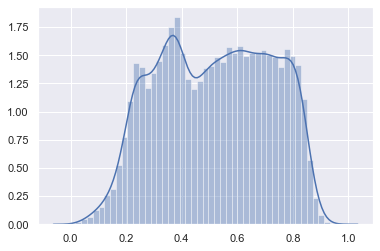

In [66]:
lgbm_pred_probs = lgbm.predict_proba(X_test)[:,1]
sns.distplot(lgbm_pred_probs)

In [67]:
lgbm_predictions = lgbm.predict(X_test)
true_positive = y_test & lgbm_predictions
false_positive = ~y_test & lgbm_predictions
true_negative = ~y_test & ~lgbm_predictions
false_negative = y_test & ~lgbm_predictions